In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!git clone https://github.com/medhanshgit/SmartSense.git

fatal: destination path 'SmartSense' already exists and is not an empty directory.


In [6]:
# Imports
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [7]:
car_data = pd.read_csv('SmartSense/data/dataTrain_carListings.csv')

In [8]:
car_data.head()

,Price,Year,Mileage,State,Make,Model
0,21490,2014,31909,MD,Nissan,MuranoAWD
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe
2,20925,2016,24633,SC,Hyundai,Santa
3,14500,2012,84026,OK,Jeep,Grand
4,32488,2013,22816,TN,Jeep,Wrangler


In [9]:
X = car_data[['Year', 'Mileage', 'State', 'Make', 'Model']]
y = car_data['Price']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets to verify the split
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (400000, 5)
y_train shape: (400000,)
X_test shape: (100000, 5)
y_test shape: (100000,)


In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 269056 to 121958
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Year     400000 non-null  int64 
 1   Mileage  400000 non-null  int64 
 2   State    400000 non-null  object
 3   Make     400000 non-null  object
 4   Model    400000 non-null  object
dtypes: int64(2), object(3)
memory usage: 18.3+ MB


##EDA

In [11]:
X_train["Make"].value_counts()

Ford             62796
Chevrolet        58326
Toyota           46029
Honda            33247
Jeep             24163
GMC              20713
Kia              16375
Dodge            16087
Hyundai          15091
Lexus            13732
BMW              12230
Volkswagen       11138
Nissan           10537
Chrysler          9082
Mercedes-Benz     7624
Subaru            6822
Cadillac          5367
Buick             4928
Ram               3599
MINI              2784
Land              2707
INFINITI          2460
Acura             2425
Mazda             2395
Volvo             1782
Lincoln           1736
Audi              1459
Mitsubishi        1301
Porsche            971
Scion              649
Jaguar             350
Pontiac            327
FIAT               266
Mercury            255
Tesla              148
Bentley             56
Suzuki              36
Freightliner         7
Name: Make, dtype: int64

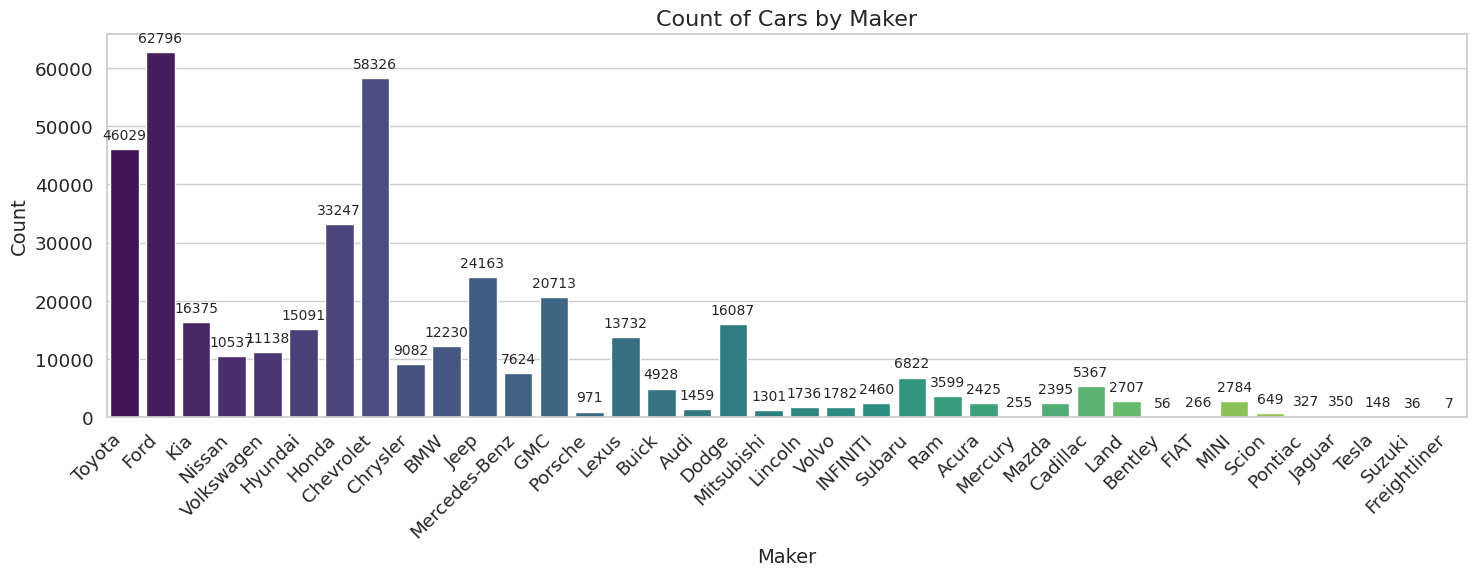

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 6))
sns.set(style="whitegrid", font_scale=1.2)

plot = sns.countplot(x='Make', data=X_train, palette="viridis")

plt.xticks(rotation=45, ha='right')

for p in plot.patches:
    height = int(p.get_height())
    x = p.get_x() + p.get_width() / 2.0
    y = height
    annotation_position = (x, y)
    annotation_offset = (0, 10)

    plot.annotate(f'{height}',
                  xy=annotation_position,
                  ha='center',
                  va='center',
                  xytext=annotation_offset,
                  textcoords='offset points',
                  fontsize=10)

plt.title("Count of Cars by Maker", fontsize=16)
plt.xlabel("Maker", fontsize=14)
plt.ylabel("Count", fontsize=14)

plt.tight_layout()
plt.show()



Maximum cars that are present in the dataset belong to Ford. Minimum Cars are present for Freightliner.

###State
State doesn't as such define the price of the car, it is the other factors that are more important when it comes to getting the price of the car.

In [13]:
X_train.drop("State", axis = 1, inplace = True)
X_test.drop("State", axis = 1, inplace = True)
X_train.head()

,Year,Mileage,Make,Model
269056,2014,13413,Toyota,CamryXLE
499174,2013,49138,Ford,F-150XLT
85143,2015,32698,Kia,OptimaEX
260335,2010,57672,Nissan,Murano2WD
338124,2007,111250,Volkswagen,Touareg4dr


Lets check the numerical coulumn that are Price, Year and Mileage

###Mileage

In [14]:
print(sum(X_train["Mileage"].isnull()))
print(sum(X_test["Mileage"].isnull()))

0
0


We can see that there are no null values in the dataset for mileage.
Lets see a scatter plot for the same.

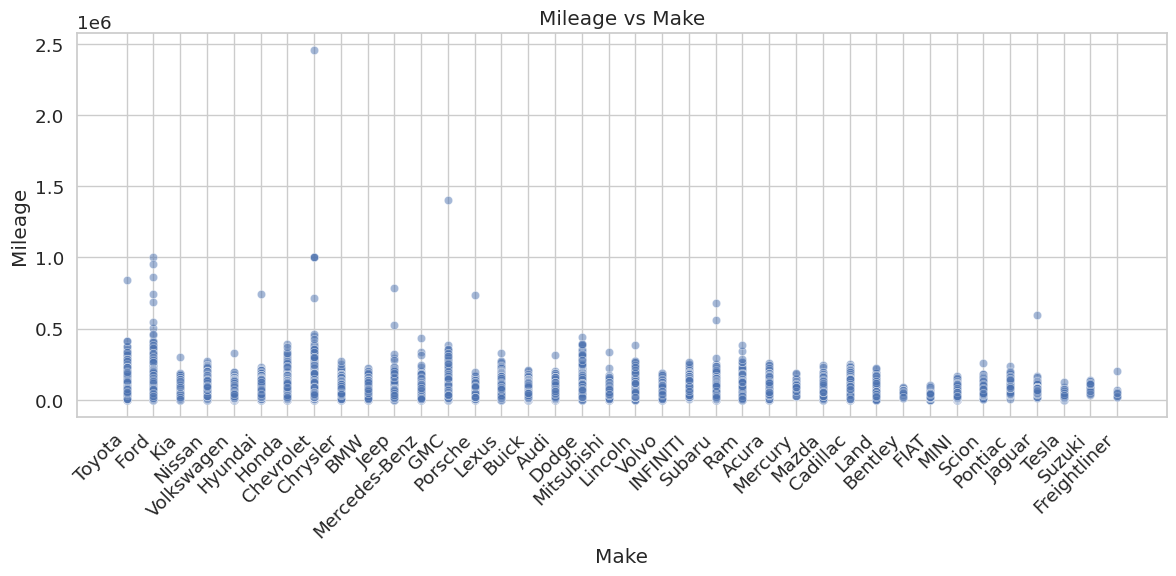

In [15]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Make', y='Mileage', data=X_train, alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Make')
plt.ylabel('Mileage')
plt.title('Mileage vs Make')
plt.tight_layout()
plt.show()

### Year

Year is important as older cars will have lesser price than newer cars.
Lets change the Year to Age as it is better estimate of the price.

In [16]:
curr_time = datetime.datetime.now()
X_train['Year'] = X_train['Year'].apply(lambda x : curr_time.year - x)
X_test['Year'] = X_test['Year'].apply(lambda x : curr_time.year - x)

In [17]:
X_train.head()

,Year,Mileage,Make,Model
269056,9,13413,Toyota,CamryXLE
499174,10,49138,Ford,F-150XLT
85143,8,32698,Kia,OptimaEX
260335,13,57672,Nissan,Murano2WD
338124,16,111250,Volkswagen,Touareg4dr


## Processing Categorical columns

Lets change the categorical columns of Make and Model into numerical by mapping.

In [18]:
from sklearn.preprocessing import LabelEncoder
X_train_encoded = X_train.copy()

make_encoder = LabelEncoder()
model_encoder = LabelEncoder()

X_train_encoded['Make'] = make_encoder.fit_transform(X_train_encoded['Make'])
X_train_encoded['Model'] = model_encoder.fit_transform(X_train_encoded['Model'])

print("Make label mapping:", dict(zip(make_encoder.classes_, make_encoder.transform(make_encoder.classes_))))
print("Model label mapping:", dict(zip(model_encoder.classes_, model_encoder.transform(model_encoder.classes_))))

print("\nModified DataFrame with encoded 'Make' and 'Model':")
print(X_train_encoded.head())


Make label mapping: {'Acura': 0, 'Audi': 1, 'BMW': 2, 'Bentley': 3, 'Buick': 4, 'Cadillac': 5, 'Chevrolet': 6, 'Chrysler': 7, 'Dodge': 8, 'FIAT': 9, 'Ford': 10, 'Freightliner': 11, 'GMC': 12, 'Honda': 13, 'Hyundai': 14, 'INFINITI': 15, 'Jaguar': 16, 'Jeep': 17, 'Kia': 18, 'Land': 19, 'Lexus': 20, 'Lincoln': 21, 'MINI': 22, 'Mazda': 23, 'Mercedes-Benz': 24, 'Mercury': 25, 'Mitsubishi': 26, 'Nissan': 27, 'Pontiac': 28, 'Porsche': 29, 'Ram': 30, 'Scion': 31, 'Subaru': 32, 'Suzuki': 33, 'Tesla': 34, 'Toyota': 35, 'Volkswagen': 36, 'Volvo': 37}
Model label mapping: {'1': 0, '15002WD': 1, '15004WD': 2, '1500Laramie': 3, '1500Tradesman': 4, '200LX': 5, '200Limited': 6, '200S': 7, '200Touring': 8, '25002WD': 9, '25004WD': 10, '3': 11, '300300C': 12, '300300S': 13, '3004dr': 14, '300Base': 15, '300Limited': 16, '300Touring': 17, '35004WD': 18, '350Z2dr': 19, '4Runner2WD': 20, '4Runner4WD': 21, '4Runner4dr': 22, '4RunnerLimited': 23, '4RunnerRWD': 24, '4RunnerSR5': 25, '4RunnerTrail': 26, '5': 2

In [19]:
X_test_encoded = X_test.copy()

X_test_encoded['Make'] = make_encoder.transform(X_test_encoded['Make'])
X_test_encoded['Model'] = model_encoder.transform(X_test_encoded['Model'])

print("\nModified DataFrame with encoded 'Make' and 'Model' for X_test:")
print(X_test_encoded.head())


Modified DataFrame with encoded 'Make' and 'Model' for X_test:
        Year  Mileage  Make  Model
104241     6    30223    18    430
199676     8    12764     6    158
140199     6    37951    10    233
132814     7    80649    32    326
408697     9    24579    36    264


##Prediction

In [20]:
standardScaler = StandardScaler()
standardScaler.fit(X_train_encoded)
X_train_encoded = standardScaler.transform(X_train_encoded)
X_test_encoded = standardScaler.transform(X_test_encoded)

In [35]:
from sklearn.metrics import mean_squared_error

linear_reg = LinearRegression()
linear_reg.fit(X_train_encoded, y_train)

y_pred = linear_reg.predict(X_test_encoded)

r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Score:", r2)

print("\nPredicted Prices:")
print(y_pred[:10])
print(y_test[:10])

R-squared (R2) Score: 0.31052919482545394

Predicted Prices:
[28447.74483169 25807.55066084 26220.7025294  20602.2292627
 21605.79487151 21838.49500168 14403.82986003 22957.01562704
 30053.23528042 11441.41250187]
104241    18231
199676    22982
140199    16219
132814    21995
408697    17995
163280    14900
215758    13800
442316    12395
6940      43256
382310     9995
Name: Price, dtype: int64


In [37]:
from sklearn.ensemble import RandomForestRegressor

# Create and train a Random Forest regressor
random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(X_train_encoded, y_train)  # Using the 'Year' and 'Mileage' subset

# Use the model to make predictions on X_test_encoded
y_pred_rf = random_forest.predict(X_test_encoded)  # Using the 'Year' and 'Mileage' subset

# Calculate R-squared (R2) score and mean squared error (MSE)
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

# Display R2 score and MSE for the Random Forest model
print("Random Forest - R-squared (R2) Score:", r2_rf)
print("Random Forest - Mean Squared Error:", mse_rf)


Random Forest - R-squared (R2) Score: 0.8521548889947516
Random Forest - Mean Squared Error: 17247892.60174664
